In [ ]:
from torch.utils.data import random_split, DataLoader, Dataset
from ignite.engine import create_supervised_trainer, create_supervised_evaluator, Engine
from ignite.metrics import Accuracy, Loss, Precision, Recall
from IPython.display import clear_output
import pandas as pd
import torch.nn as nn
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
from ignite.engine import Events
from google.colab import files

In [ ]:
# pip install pytorch-ignite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.4/272.4 kB 2.2 MB/s eta 0:00:00


In [ ]:
uploaded = files.upload()
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c ml-intensive-yandex-autumn-2023
!unzip ml-intensive-yandex-autumn-2023.zip

In [ ]:
# create a class with custom dataset
class Data(Dataset):

    def __init__(self, images_path, labels_path, transform=transforms.Compose([]), masked=False):
        self.labels = pd.read_csv(labels_path)
        self.images_path = images_path
        # transfrom image to tensor
        self.transform = transform
        # if masked true, crop images with mask
        self.masked = masked

    def implement_lung_masks(self, mask, original_image):
        # mask has 255 rgb white and black elements
        masked_image = mask * original_image
        return masked_image

    def __getitem__(self, idx):
        # if idx is tensor
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # image name
        name = f'{self.images_path}/img_{idx}.png'
        # image label
        lungs = self.labels.iloc[idx, 1]
        image = Image.open(name)
        # if masked is true
        if self.masked:
            mask_image = self.transform(Image.open(f'data/train_lung_masks/img_{idx}.png'))
            lung = self.implement_lung_masks(mask_image, self.transform(image))
        lung = self.transform(image)
        return lung, lungs

    def show_examples(self, idx):
        # show images
        image = f'{self.images_path}/img_{idx}.png'
        img = self.transform(Image.open(image))
        if self.masked:
            mask = self.transform(Image.open(f'data/train_lung_masks/img_{idx}.png'))
            img = self.implement_lung_masks(mask, img)
        to_pil_transform = transforms.ToPILImage()
        return to_pil_transform(img)

    def __len__(self):
        return len(self.labels)

In [ ]:
transform_ = transforms.Compose([
    transforms.ToTensor(),
])
masked = False
data = Data(images_path='data/train_images', labels_path='data/train_answers.csv', transform=transform_, masked=masked)

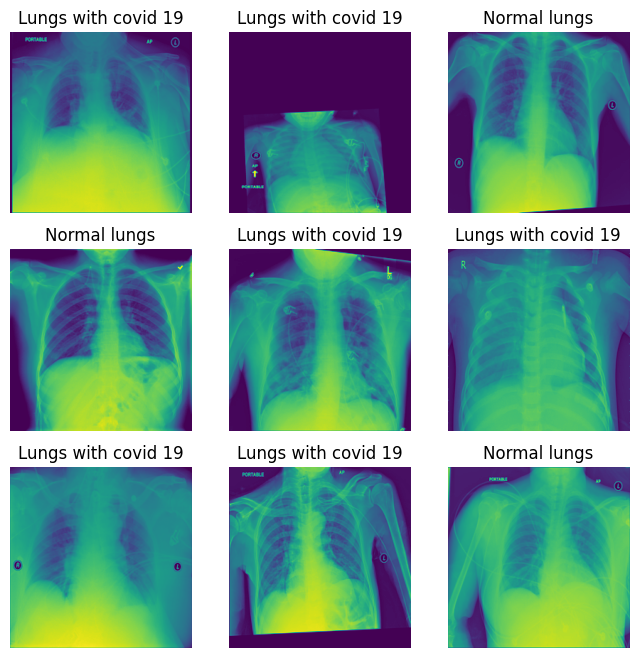

In [ ]:
def show_transformed(dataset):
    # to show labels in convenient format
    labels_map = {0: 'Normal lungs', 1: 'Lungs with non_covid', 2: 'Lungs with covid 19'}
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        # to pick random images
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        _, label = dataset[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(labels_map[label])
        plt.axis("off")
        # call a function
        plt.imshow(data.show_examples(sample_idx))
    plt.show()


show_transformed(data)

In [ ]:
# split dataset 0.95:0.05
dataset_length = len(data)
train_size = int(0.95 * dataset_length)
test_size = dataset_length - train_size

train, test = random_split(data, [train_size, test_size])

In [ ]:
BATCH_SIZE = 128
train_loader = DataLoader(train, batch_size=BATCH_SIZE)
validation_loader = DataLoader(test, batch_size=BATCH_SIZE)

In [ ]:
def change_cpu():
    return 'cuda:0' if torch.cuda.is_available() else 'cpu'


device = change_cpu()

In [ ]:
class Model(nn.Module):
    def __init__(self, num_classes=3):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, padding=1)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, padding=1)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, padding=1)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.conv5 = nn.Conv2d(256, 256, kernel_size=5, padding=2)
        self.bn5 = nn.BatchNorm2d(256)
        self.relu5 = nn.Tanh()
        self.pool5 = nn.MaxPool2d(kernel_size=2, padding=1)

        self.conv6 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(512)
        self.relu6 = nn.ReLU(inplace=True)
        self.pool6 = nn.AvgPool2d(kernel_size=2, padding=1)

        self.conv7 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(512)
        self.relu7 = nn.Tanh()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512 * 5 * 5, 256)
        self.relu5 = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(0.2)

        self.fc2 = nn.Linear(256, 128)
        self.relu6 = nn.ReLU(inplace=True)
        self.dropout2 = nn.Dropout(0.2)

        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = self.pool4(self.relu4(self.bn4(self.conv4(x))))
        x = self.pool5(self.relu5(self.bn5(self.conv5(x))))
        x = self.pool6(self.relu6(self.bn6(self.conv6(x))))
        x = self.relu7(self.bn7(self.conv7(x)))
        x = self.flatten(x)
        x = self.dropout1(self.relu5(self.fc1(x)))
        x = self.dropout2(self.relu6(self.fc2(x)))
        x = self.fc3(x)
        return x

In [ ]:
model=Model(num_classes=3).to(device)
summary(model,input_size=(1,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]           1,600
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
         MaxPool2d-4         [-1, 32, 129, 129]               0
            Conv2d-5         [-1, 64, 129, 129]          51,264
       BatchNorm2d-6         [-1, 64, 129, 129]             128
              ReLU-7         [-1, 64, 129, 129]               0
         MaxPool2d-8           [-1, 64, 65, 65]               0
            Conv2d-9          [-1, 128, 65, 65]          73,856
      BatchNorm2d-10          [-1, 128, 65, 65]             256
             ReLU-11          [-1, 128, 65, 65]               0
        MaxPool2d-12          [-1, 128, 33, 33]               0
           Conv2d-13          [-1, 256, 31, 31]         295,168
      BatchNorm2d-14          [-1, 256,

In [ ]:
def draw_plots(train_accuracy, validation_accuracy, train_loss_, validation_loss_):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Train accuracy plot
    axes[0, 0].plot(train_accuracy, color='blue', linestyle='--', label='train accuracy')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].legend()

    # Validation accuracy plot
    axes[0, 1].plot(validation_accuracy, color='red', linestyle='--', label='validation accuracy')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].legend()

    # Train loss plot
    axes[1, 0].plot(np.array(train_loss_), color='blue', linestyle='--', label='train loss')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].legend()

    # Validation loss plot
    axes[1, 1].plot(np.array(validation_loss_), color='red', linestyle='--', label='validation loss')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# adam accelerates training process
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6, weight_decay=1e-6)
loss_type = torch.nn.CrossEntropyLoss()
#  Firstly train on 4 epochs with learning rate = 1e-4, after set lr to 1e-6 and train 10 epochs with weight decay 1e-6
epochs = 4
matrix = []
train_loss, validation_loss = [], []
train_accuracy, validation_accuracy = [], []
torch.save(model.state_dict(), "model_saved.mdl")

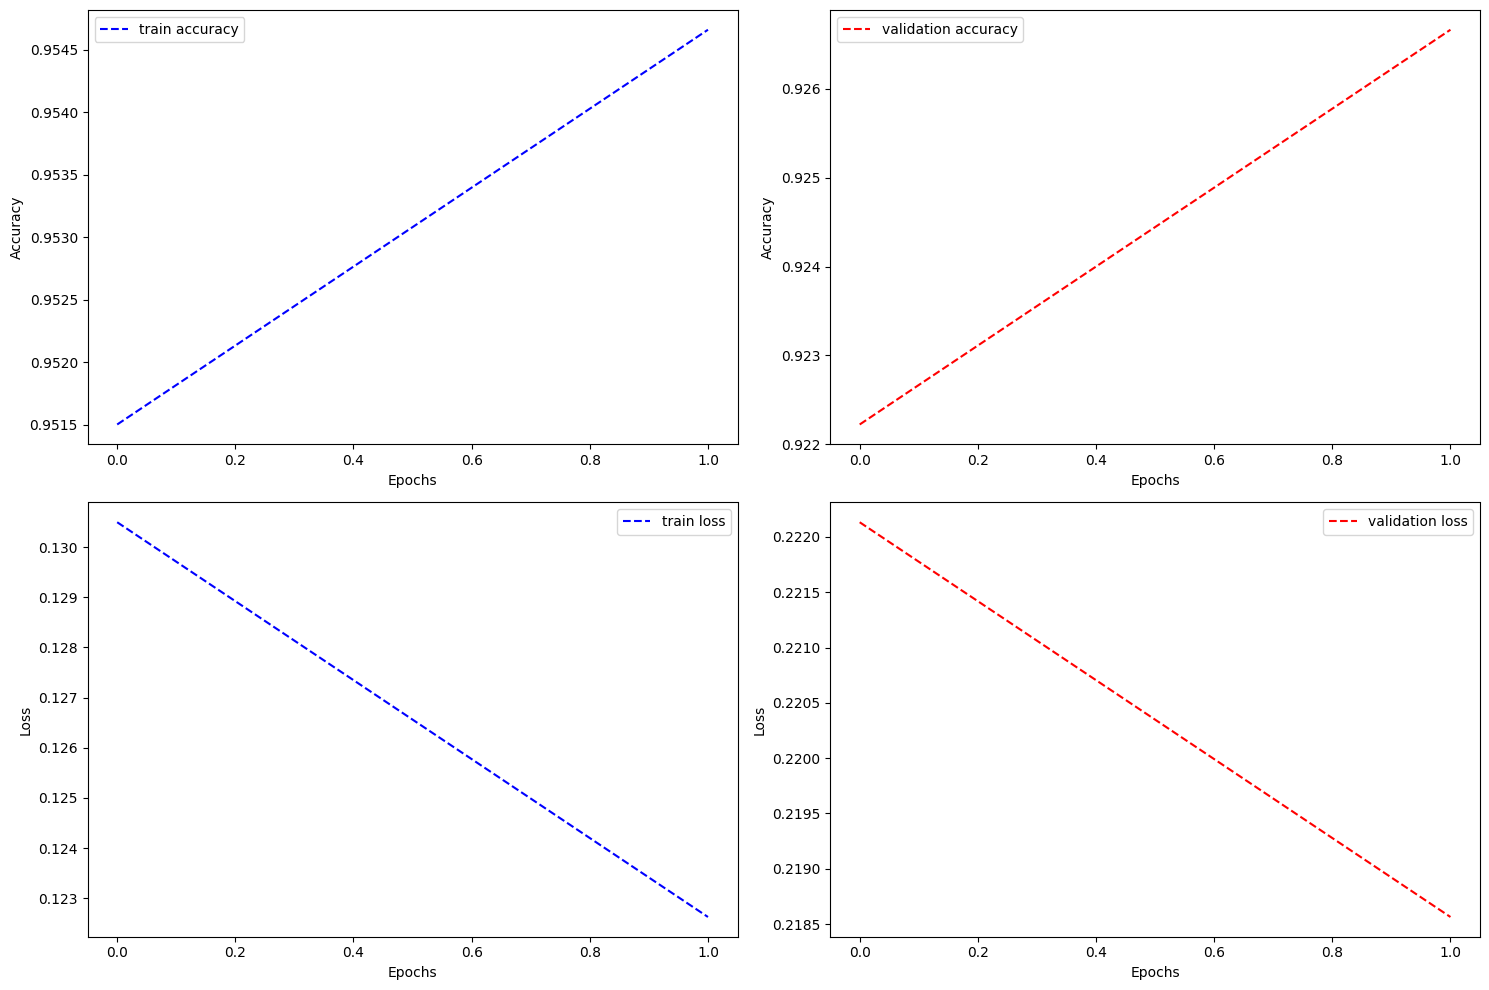

Epoch 2 from 4


ERROR:ignite.engine.engine.Engine:Engine run is terminating due to exception: 


KeyboardInterrupt: ignored

In [ ]:
for epoch in range(epochs):
    model.load_state_dict(torch.load("model_saved.mdl"))

    loss_value, iteration = [], []


    # print results of epoch
    def print_epoch_results(engine, type_train_eval=""):
        result = "\t".join([f"{i}:{j}" for i, j in engine.state.metrics.items()])
        print(f"Results after {type_train_eval} epoch:", result)


    # draw the change in loss value after each iteration
    def draw_loss_iteration(engine):
        iteration.append(engine.state.iteration)
        loss_value.append(engine.state.output)
        clear_output()
        plt.figure(figsize=(10, 5))
        plt.title('Loss')
        # blue line with dots
        plt.plot(iteration, loss_value, 'bo:')
        plt.show()


    # extract accuracy values and loss from evaluator object and draw plots.
    def one_epoch(engine):
        train_eval.run(train_loader)
        valid_eval.run(validation_loader)
        validation_results = valid_eval.state.metrics
        train_results = train_eval.state.metrics
        train_accuracy.append(train_results['Accuracy'])
        validation_accuracy.append(validation_results['Accuracy'])
        train_loss.append(train_results['Loss'])
        validation_loss.append(validation_results['Loss'])
        clear_output()
        draw_plots(train_accuracy, validation_accuracy,
                   train_loss, validation_loss)


    trainer = create_supervised_trainer(model, optimizer, loss_type, device)
    # choose metrics to train
    metrics_for_task = {
        "Accuracy": Accuracy(),
        "Precision": Precision().mean(),
        "Recall": Recall().mean(),
        "F1-score": ((Precision() * Recall() * 2) / (Precision() + Recall())).mean(),
        "Loss": Loss(loss_type)
    }

    train_eval = create_supervised_evaluator(model, device=device, metrics=metrics_for_task)
    valid_eval = create_supervised_evaluator(model, device=device, metrics=metrics_for_task)
    # renew the graph after 25 iterations
    trainer.add_event_handler(Events.ITERATION_COMPLETED(every=25), draw_loss_iteration)
    # after eah epoch plot graphs
    trainer.add_event_handler(Events.EPOCH_COMPLETED, one_epoch)
    # print train and validation results
    train_eval.add_event_handler(Events.EPOCH_COMPLETED, print_epoch_results, type_train_eval="Train")
    valid_eval.add_event_handler(Events.EPOCH_COMPLETED, print_epoch_results, type_train_eval="Validation")

    print(f'Epoch {epoch} from {epochs}')
    trainer.run(train_loader)
    torch.save(model.state_dict(), "model_saved.mdl")

In [ ]:
model.load_state_dict(torch.load("model_saved.mdl"))

<All keys matched successfully>

In [ ]:
num_ans = 6920

with open('100.csv', 'w') as csv_file:
    csv_file.write('id,target_feature\n')

    for i in range(num_ans):
        image_name = f'data/test_images/img_{i}.png'
        image = Image.open(image_name)
        image_tensor = transform_(image).unsqueeze(0).to(device)
        with torch.no_grad():
            output_probs = model(image_tensor)
        ans = torch.argmax(output_probs).item()

        to_write = f'{i},{ans}\n'
        csv_file.write(to_write)

print('Done')

Done
